# Machine Learning Project - RandomForest + PCA + Hyperparameter Optimization

## Objective: Prediction task is to determine whether a person makes over 50K a year.

## Background info and Libraries

In [26]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost

In [3]:
df_train = pd.read_csv('train.csv', na_values='?')
df_test = pd.read_csv('test.csv', na_values='?')

In [4]:
# Important!!! 

# targets in training set are ['<=50K', '>50K']
# targets in testing set are ['<=50K.', '>50K.']

# consistency is needed!!!

df_train['income'] = df_train['income'].map({'>50K':1, '<=50K':0})
df_test['income'] = df_test['income'].map({'>50K.':1, '<=50K.':0})

In [5]:
# concat to form a new dataframe

df = pd.concat([df_train, df_test], axis=0)

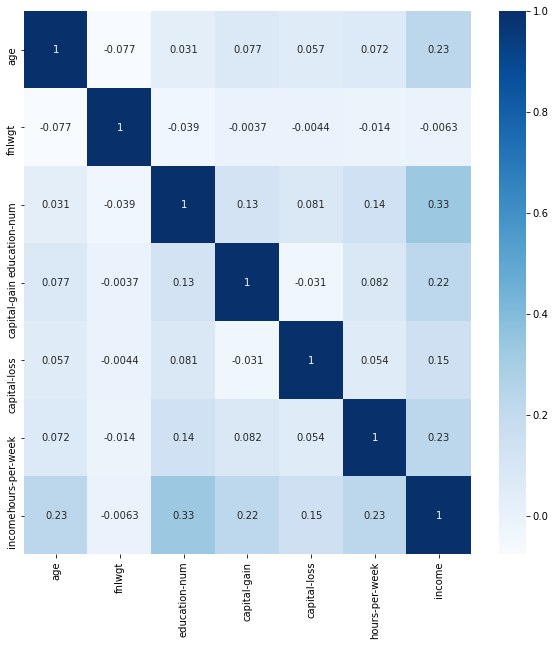

In [6]:
## Correlation
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="Blues")

## Data Preprocessing

In [7]:
# drop 'fnlwgt' column coz it is not that correlated to 'income'

# drop 'education' column coz the information that it gives us is the same as 'education-num'
# the higher the 'education' , the larger the 'education-num'

df = df.drop(['fnlwgt', 'education'], axis=1)

In [8]:
df.info() #confirm dropping of columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   education-num   48842 non-null  int64 
 3   marital-status  48842 non-null  object
 4   occupation      46033 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   sex             48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  47985 non-null  object
 12  income          48842 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 5.2+ MB


In [9]:
#Checking with missing values

df.isna().sum()

age                  0
workclass         2799
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [10]:
# find % of missing values in each column

print("% of missing values in each column")
print("\n")
for i in df.columns:
    print(f"{df[{i}].isna().sum()/len(df)*100}")
    print("---------------------------")

% of missing values in each column


age    0.0
dtype: float64
---------------------------
workclass    5.730724
dtype: float64
---------------------------
education-num    0.0
dtype: float64
---------------------------
marital-status    0.0
dtype: float64
---------------------------
occupation    5.751198
dtype: float64
---------------------------
relationship    0.0
dtype: float64
---------------------------
race    0.0
dtype: float64
---------------------------
sex    0.0
dtype: float64
---------------------------
capital-gain    0.0
dtype: float64
---------------------------
capital-loss    0.0
dtype: float64
---------------------------
hours-per-week    0.0
dtype: float64
---------------------------
native-country    1.754637
dtype: float64
---------------------------
income    0.0
dtype: float64
---------------------------


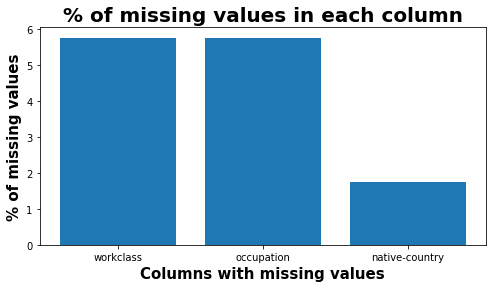

In [11]:
# visualization of missing values

x_list=[]
y_list=[]

for i in df.columns:
    if df[i].isna().sum()/len(df)*100 != 0:
        x_list.append(i)
        y_list.append(df[i].isna().sum()/len(df)*100)

plt.figure(figsize=(8,4))
plt.bar(x_list, y_list)
plt.xticks(rotation=0)
plt.title('% of missing values in each column', size=20, fontweight="bold")
plt.xlabel('Columns with missing values', size=15, fontweight="bold")
plt.ylabel('% of missing values', size=15, fontweight="bold")
plt.show()

In [12]:
# since columns with missing values : 'workclass', 'occupation', 'native_country'
# are all catagorical data
# so fill in by proportional mode

for i in x_list:
    s = df[i].value_counts(normalize=True)
    df.loc[df[i].isna(), i] = np.random.choice(s.index, p=s.values, size=df[i].isna().sum())

In [13]:
df.isna().sum()       # done! no more missing values 

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [14]:
#Converting Categorical Data to Dummy Variables

# find out all categorical columns 
categorical = []
for i in df.columns:
    if df[i].dtype == 'object':
        categorical.append(i)

In [15]:
# apply get_dummies on each categorical column

dummy = []
for k in categorical:
    df_k = pd.get_dummies(df[k], drop_first=True)
    dummy.append(df_k)

In [16]:
# concat all the newly created dataframes

df_dummy = pd.concat(dummy, axis=1)

In [17]:
# finally concat back to the original dataframe

df = pd.concat([df, df_dummy], axis=1)

In [18]:
# drop the original categorical columns

for i in categorical:
    df = df.drop([i], axis=1)

In [19]:
df.shape

(48842, 82)

In [20]:
# Fixing Imbalances by up-scaling

df.income.value_counts(normalize=True)      # data imbalance!

0    0.760718
1    0.239282
Name: income, dtype: float64

In [21]:
majority, minority = df.income.value_counts() # class counts

# divide by class

df_majority = df[df['income'] == 0]
df_minority = df[df['income'] == 1]


df_minority_up = df_minority.sample(majority, replace=True) # scale up the minority

df_final = pd.concat([df_majority, df_minority_up], axis=0)  # concat to form a new/final dataframe

In [22]:
print('df_final')
print(df_final.income.value_counts(normalize=True))   # imbalance problem solved!!!

df_final
0    0.5
1    0.5
Name: income, dtype: float64


## Split Data to Train and Test Sets

In [23]:
x = df_final.drop('income', axis=1) # Use all variables except income
y = df_final['income'] #Income is target variable

# original training set = 32561 data pt.
# original testing set = 16281 data pt.
# ratio = 65% : 35%
# so, set the test_size = 0.3

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## Feature Scaling 

In [24]:
# scale the training and testing data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Checking Different Classification Algorithms to see which one works

In [27]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier(n_estimators=50,n_jobs=-1))) #We chose this
models.append(('XGB', xgboost.XGBClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model  in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: 0.820924 (0.004085)
LDA: 0.806621 (0.004252)
KNN: 0.826230 (0.004747)
CART: 0.889421 (0.003450)
NB: 0.671953 (0.010851)
SVM: 0.825250 (0.004761)
RFC: 0.906627 (0.004121)
[17:17:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nchan94/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: 0.859008 (0.005165)


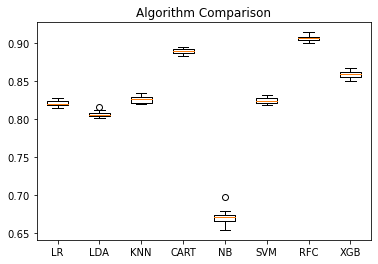

In [28]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show() #KNN, RandomForest, and XGBoost seem to perform well. I proceeded with RandomForest

# RandomForest Baseline Check (Without Hyperparameter, or PCA)

In [33]:
# create Random Forest classifier

rnd_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

# train the model using training set

rnd_clf.fit(x_train, y_train)

# make predictions using testing set

y_pred_rf = rnd_clf.predict(x_test)
                            
#Accuracy of Prediction
                            
print("Accuracy Score: ", accuracy_score(y_test, y_pred_rf))

Accuracy Score:  0.9123491679002378


In [34]:
#RandomForest Model Evaluation

from sklearn.metrics import classification_report
print("Testing Report")
print("--------------")
print(f"{classification_report(y_test,y_pred_rf)}") #Random Forest performing better

Testing Report
--------------
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     11155
           1       0.88      0.96      0.92     11138

    accuracy                           0.91     22293
   macro avg       0.92      0.91      0.91     22293
weighted avg       0.92      0.91      0.91     22293



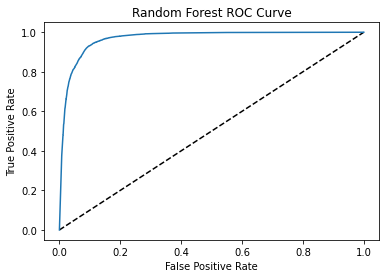

In [35]:
#ROC Curve

y_pred_prob = rnd_clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [36]:
print('ROC-AUC Score: ', roc_auc_score(y_test, y_pred_prob))

ROC-AUC Score:  0.9689727238388791


## RandomForest Hyperparameter Tuning (No PCA, Random Search --> GridSearch)

In [37]:
#RandomizedSearch

# Number of trees in random forest
n_estimators = [10,100,1000]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 100, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 1000]},
                   random_state=42, verbose=2)

In [39]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels,predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [40]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.91%.
Model Performance
Accuracy = 0.92%.
Improvement of 0.86%.


In [41]:
best_random

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       n_estimators=1000)

In [43]:
#GridSearch based on RandomSearch 

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [35, 40, 45, 50,55,60],
    'min_samples_split' : [4, 5, 6],
    'n_estimators': [950,1000,1050,1100]
}

# Create a based model
rf_gd = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_gd, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [44]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'bootstrap': False,
 'max_depth': 40,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [45]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_train, y_train) #best one so far
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.97%.
Improvement of 7.06%.


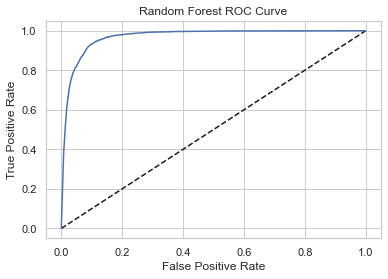

In [72]:
y_pred_prob = rnd_clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [47]:
print('ROC-AUC Score: ', roc_auc_score(y_test, y_pred_prob))

ROC-AUC Score:  0.9689729331038609


## RandomForest Hyperparameter Tuning (With PCA, Random Search --> GridSearch)

0.9753734356075898

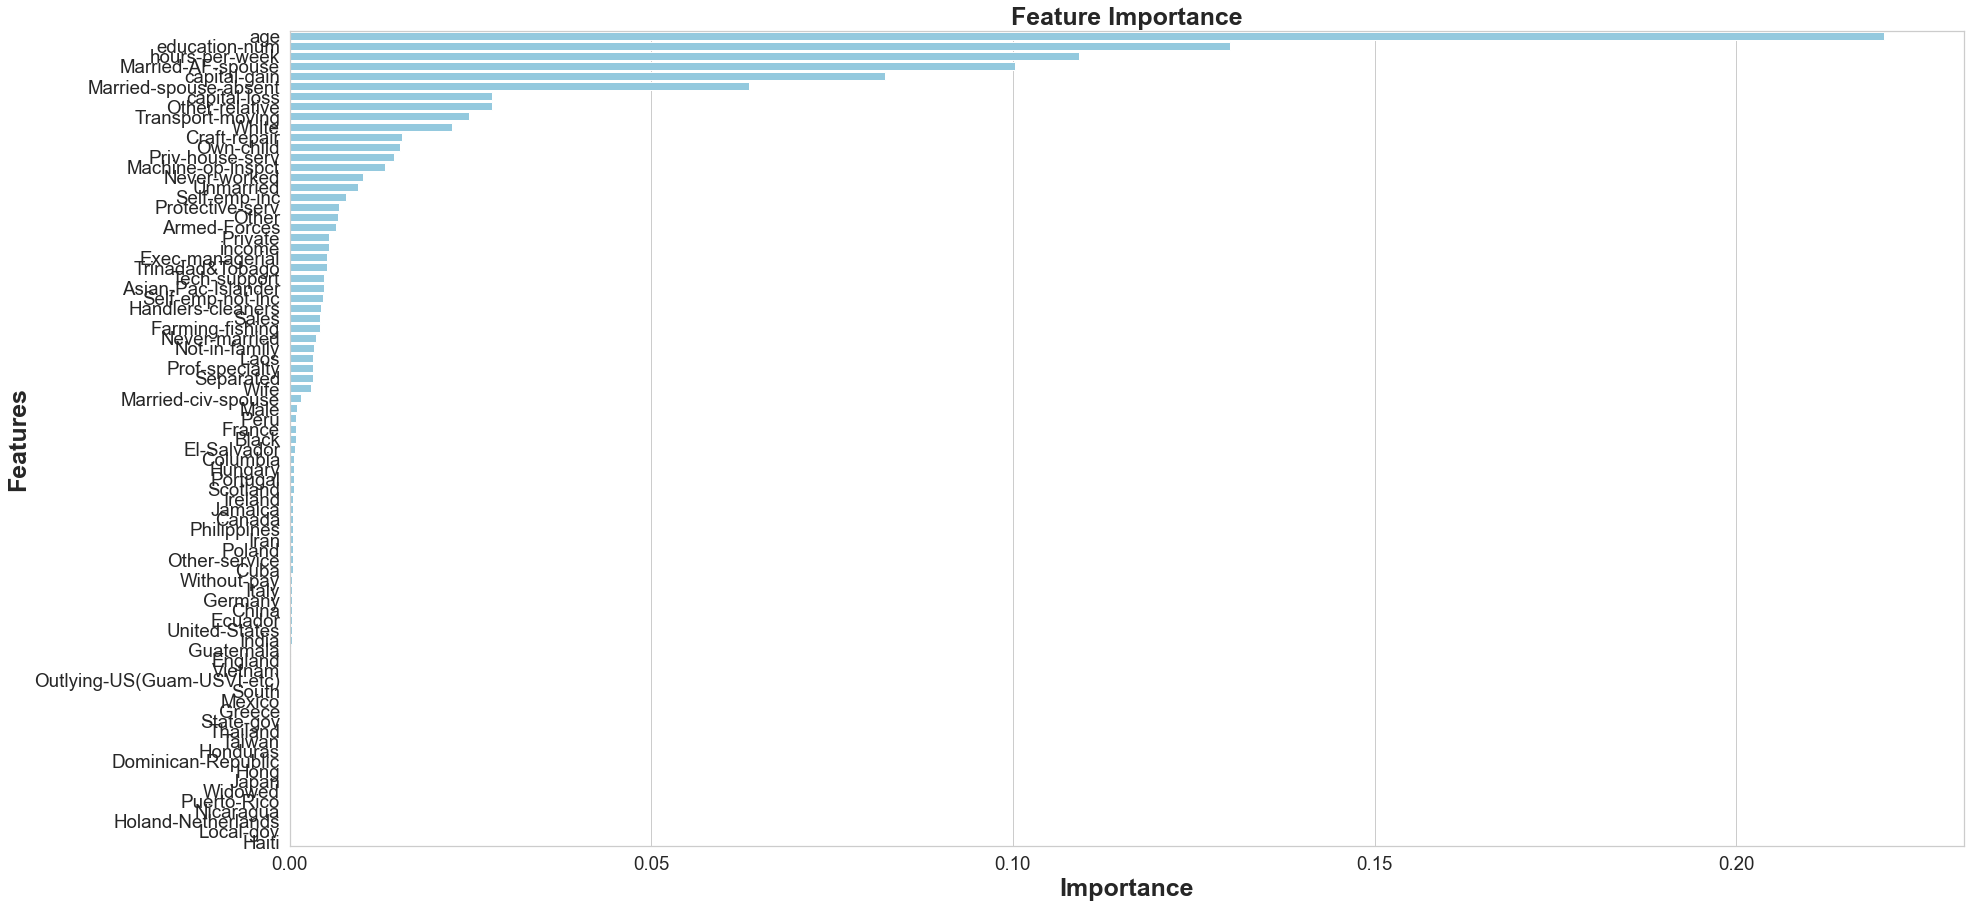

None

,Features,Gini-Importance
0,age,2.204029e-01
1,education-num,1.300367e-01
2,hours-per-week,1.091869e-01
3,Married-AF-spouse,1.003037e-01
4,capital-gain,8.229929e-02
...,...,...
76,Puerto-Rico,5.188845e-05
77,Nicaragua,5.064613e-05
78,Holand-Netherlands,1.626299e-05
79,Local-gov,5.820191e-06


In [54]:
#Understanding the level of importance of each feature
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
display(rfc.score(x_train, y_train))

feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)


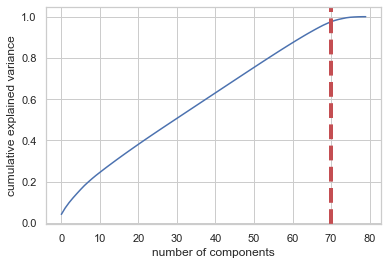

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.041836,0.041836
1,0.072700,0.030864
2,0.098461,0.025762
3,0.121027,0.022566
4,0.142005,0.020978
...,...,...
65,0.928985,0.010532
66,0.939381,0.010396
67,0.949384,0.010003
68,0.959003,0.009619


In [55]:
pca_test = PCA(n_components=80)
pca_test.fit(x_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=70, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(70))

In [56]:
pca = PCA(n_components=70) # Based on above analysis I forced the PCA to reduce to 70 components
pca.fit(x_train)
x_train_pca = pca.transform(x_train) #Lower case x!
x_test_pca = pca.transform(x_test) #Lower case x!

pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_,index=pca_dims) # columns = df.columns
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
0,-0.275858,0.095253,0.069737,0.293544,0.167614,-0.050877,-0.160873,0.064911,-0.127882,-0.032096
1,-0.196633,0.038004,0.350673,-0.281566,-0.061643,-0.223534,-0.054555,-0.137274,0.063939,0.123093
2,-0.093795,0.043547,0.076787,-0.084395,0.010607,-0.060029,-0.109203,-0.000872,0.170266,0.123525
3,-0.083502,0.018141,0.026396,-0.031535,-0.015310,-0.059639,-0.039398,-0.007220,0.047747,-0.035555
4,-0.214800,0.037219,-0.026881,-0.080254,-0.034969,0.068510,-0.279300,-0.150969,0.122960,0.044967
...,...,...,...,...,...,...,...,...,...,...
76,0.005683,0.074330,-0.002596,-0.039374,-0.007609,-0.013686,-0.021688,0.040201,0.001551,-0.084839
77,0.015797,0.043860,-0.000283,0.037026,-0.022378,0.026127,0.009009,-0.049059,0.063663,0.013298
78,-0.091398,-0.464667,0.190177,0.134408,-0.346250,-0.026117,-0.089807,0.148798,-0.081504,0.029717
79,0.028410,0.116222,-0.017002,-0.052777,-0.027966,-0.013589,-0.004109,0.094939,-0.085213,-0.054059


In [57]:
rfc = RandomForestClassifier()
rfc.fit(x_train_pca, y_train)
display(rfc.score(x_train_pca,y_train)) #Pretty high accuracy!

0.9753542111232866

In [48]:
#Applying PCA Analysis before Conducting Hyperparameter Tuning with PCA setting to explain 95% of variance

from sklearn.decomposition import PCA
#pca = PCA(n_components = 4)
pca = PCA(0.95)
X_train_pca = pca.fit_transform(x_train)
X_test_pca = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_


In [51]:
#Training the Random Forest Model With no Parameters
classifier = RandomForestClassifier()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca)

In [52]:
#Making a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 9587  1568]
 [  525 10613]]


In [53]:
print('Accuracy: ' +str(accuracy_score(y_test, y_pred))) #Same as orignal, which signals to me that using previous PCA code is better

Accuracy: 0.9061140268245638


In [63]:
#Another Method

#Training the Random Forest Model With Parameters from previous steps with 70 components
classifier = RandomForestClassifier(n_estimators = 1000, max_depth=40,bootstrap = False, min_samples_split = 4)
classifier.fit(x_train_pca, y_train) #Lower case x!
#Prediction part
y_pred = classifier.predict(x_test_pca) #Lower case x!
#Making a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ' +str(accuracy_score(y_test, y_pred))) #91%, same as original

[[ 9743  1412]
 [  577 10561]]
Accuracy: 0.910779168348809


In [64]:
#Another Method, completely new Randomize Search with Trained PCA X data 70 Components
#Same conditions as previous RandomizeSearch

# Number of trees in random forest
n_estimators = [10,100,1000]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(estimator = rf, 
                        param_distributions = param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 2, 
                        n_jobs=-1)
rs.fit(x_train_pca, y_train) #Lower case x!
rs.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': False}

In [65]:
#Grid Search with new Params

#GridSearch based on RandomSearch 

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_features': ['log2'],
    'min_samples_split': [1,2,3],
    'min_samples_leaf':[1,2,3],
    'max_depth': [25, 30, 35],
    'min_samples_split' : [4, 5, 6],
    'n_estimators': [950,1000,1050]
}

# Create a based model
rf_gd = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_gd, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [66]:
# Fit the grid search to the data
grid_search.fit(x_train_pca, y_train) #Lower case x!
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 25,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1000}

In [67]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_train_pca, y_train) #best one so far #Lower case x!
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.97%.
Improvement of 7.20%.


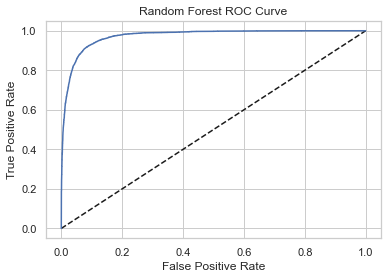

In [73]:
y_pred_prob = grid_search.predict_proba(x_test_pca)[:,1] #Lower case x!
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [74]:
print('ROC-AUC Score: ', roc_auc_score(y_test, y_pred_prob)) #97%

ROC-AUC Score:  0.9727115606587953
